In [108]:
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import torch.optim as optim

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from torchmetrics import Accuracy

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from tqdm import tqdm

from nltk.corpus import stopwords
import nltk
import string
import re

plt.style.use('dark_background')

## Upload data

In [2]:
df = pd.read_csv('/kaggle/input/phishing-email-dataset/phishing_email.csv')

In [3]:
df.head()

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0


## Visualization data

<Axes: xlabel='label', ylabel='count'>

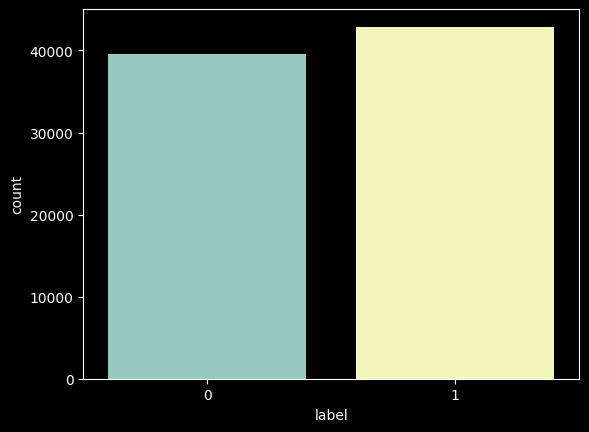

In [101]:
sns.countplot(df, x='label')

In [5]:
df.isna().sum()

text_combined    0
label            0
dtype: int64

## Cleaned data

In [6]:
 def cleaned_data(text):
        text = text.lower()
        text = re.sub(r'\d+', '', text) # remove numbers
        text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
        text = re.sub(r'\W', ' ', text)
        return text

In [7]:
df['text_combined'] = df['text_combined'].apply(cleaned_data)

## Tokenization

In [109]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
tokenizer = get_tokenizer('basic_english')

def get_yield_tokenizer(batch):
    for txt, _ in batch:
        token = [tk for tk in tokenizer(txt) if tk not in stop_words]
        
        yield token

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
c = 0
for s in get_yield_tokenizer(df.values):
    print(s)
    c += 1
    if c == 5:
        break

['hpl', 'nom', 'may', 'see', 'attached', 'file', 'hplno', 'xls', 'hplno', 'xls']
['nom', 'actual', 'vols', 'th', 'forwarded', 'sabrae', 'zajac', 'hou', 'ect', 'pm', 'enron', 'capital', 'trade', 'resources', 'corp', 'eileen', 'ponton', 'davilal', 'txu', 'com', 'cstonel', 'txu', 'com', 'mjones', 'txu', 'com', 'hpl', 'scheduling', 'enron', 'com', 'liz', 'bellamy', 'enron', 'com', 'szajac', 'enron', 'com', 'cc', 'subject', 'nom', 'actual', 'vols', 'th', 'agree', 'nomination', 'forwarded', 'eileen', 'ponton', 'houston', 'pefs', 'pec', 'charlie', 'stone', 'eileen', 'ponton', 'melissa', 'jones', 'com', 'hpl', 'scheduling', 'enron', 'com', 'liz', 'bellamy', 'enron', 'com', 'szajac', 'enron', 'com', 'subject', 'nom', 'actual', 'vols', 'th', 'pm', 'agree', 'nominated', 'volume', 'records', 'reflect', 'following', 'nom', 'schedule', 'rate', 'eff', 'hrs', 'hour', 'beginning', 'hrs', 'rate', 'eff', 'hrs', 'hour', 'beginning', 'hrs', 'rate', 'eff', 'hrs', 'hour', 'beginning', 'hrs', 'total', 'nomina

In [12]:
vocab = build_vocab_from_iterator(get_yield_tokenizer(df.values), specials=['<unk>'])

In [13]:
vocab.set_default_index(vocab['<unk>'])

In [14]:
vocab.get_itos()[:20]

['<unk>',
 'enron',
 'aug',
 'email',
 'please',
 'new',
 'one',
 'ect',
 'submissionid',
 'would',
 'time',
 'company',
 'information',
 'us',
 'get',
 'top',
 'may',
 'com',
 'message',
 'list']

In [100]:
text_pipeline = lambda x: vocab(tokenizer(x))

## Created DataLoader

In [17]:
train, validation = train_test_split(df.values, random_state=42, test_size=.2)

In [18]:
val, test = train_test_split(validation, random_state=42, test_size=.5)

In [19]:
BATCH = 20

In [106]:
def collate_batch(batch):
    features, targets = zip(*batch)
    
    texts = []
    
    # Pad the features to make them of the same length within the batch
    for txt in features:
        text = text_pipeline(txt)
        texts += [text]
    
    max_len = 50
    
    padded_features = []
    for text in texts:
        if len(text) > 50:
            text = text[:50]
        else:
            text += (max_len - len(text)) * [0]
        padded_features.append(torch.tensor(text))

    # Stack the padded features and targets into tensors
    return torch.stack(padded_features), torch.tensor(targets, dtype=torch.float32).reshape(BATCH, 1)

In [21]:
train_loader = DataLoader(train, batch_size=BATCH, collate_fn=collate_batch, shuffle=True, drop_last=True)
val_loader = DataLoader(val, batch_size=BATCH, collate_fn=collate_batch, drop_last=True)
test_loader = DataLoader(test, batch_size=BATCH, collate_fn=collate_batch, drop_last=True)

In [22]:
for x, y in train_loader:
    print(x.shape)
    break

torch.Size([20, 50])


## Architecture RNN

In [107]:
emb_dim = 50
hidden_dim = 50
n_layers = 1
vocab_size = len(vocab)

In [24]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, n_layers=1):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.RNN(emb_dim, hidden_dim, batch_first=True, num_layers=n_layers)
        self.linear = nn.Linear(hidden_dim, 1)
        self.act = nn.Sigmoid()
    
    def forward(self, x):
        x = self.embedding_layer(x)

        t = torch.randn(n_layers, len(x), hidden_dim).to(DEVICE)
        x, hidden = self.rnn(x, t)
        x = self.linear(x)
        x = self.act(x)
        
        return x[:, -1]

## Train

In [25]:
learning_rate = 0.001
step_size = 10
epochs = 20
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
rnn = RNNClassifier(vocab_size, emb_dim, hidden_dim, n_layers)
rnn = rnn.to(DEVICE)

optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)
loss_function = nn.BCELoss()
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
accuracy = Accuracy(task='binary').to(DEVICE)

In [27]:
losses_train = []
train_loss = []
acc_train = []
total_acc_train = []

losses_val = []
val_loss = []
acc_val = []
total_acc_val = []

In [28]:
# Train
for epoch in range(epochs):
    
    print(f"Epoch {epoch + 1}")

    for iteration, (X_batch, y_batch) in (pbar := tqdm(enumerate(train_loader), 
                                                  total=len(train_loader))):
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        
        rnn.train()
        
        optimizer.zero_grad()
        
        out = rnn(X_batch)
        loss = loss_function(out, y_batch)       
       
        losses_train.append(loss.detach().cpu().numpy().item())
        acc = accuracy(out, y_batch)
        acc_train.append(acc.item())
        
        loss.backward()
        optimizer.step()
    
        pbar.set_description(f'Train: loss: {loss:.5f}\taccuracy: {acc.item():.3f}')

        
    scheduler.step(loss)
    train_loss.append(np.mean(losses_train))
    total_acc_train.append(np.mean(acc_train))
    print(f"Train Error: \n Accuracy: {total_acc_train[-1]} Avg loss: {train_loss[-1]}")
    
# Validation
    for iteration, (X_batch, y_batch) in (pbar := tqdm(enumerate(val_loader),                                                 
                                                  colour='#ff0000', 
                                                  total=len(val_loader))):
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        
        rnn.eval()
        with torch.no_grad():
            pred = rnn(X_batch)
            losses = loss_function(pred, y_batch)
            
            losses_val.append(losses.detach().cpu().numpy().item())
            acc = accuracy(pred, y_batch)
            acc_val.append(acc.item())
    
    val_loss.append(np.mean(losses_val))
    total_acc_val.append(np.mean(acc_val))
    print(f'Validation Error: \n Accuracy: {total_acc_val[-1]} Avg Loss: {val_loss[-1]}')      

Epoch 1


Train: loss: 0.39547	accuracy: 0.850: 100%|██████████| 3299/3299 [00:40<00:00, 81.88it/s]


Train Error: 
 Accuracy: 0.7758714767180273 Avg loss: 0.4856379007518057


100%|██████████| 412/412 [00:02<00:00, 196.77it/s]


Validation Error: 
 Accuracy: 0.8667475702693161 Avg Loss: 0.3534001076901422
Epoch 2


Train: loss: 0.18854	accuracy: 0.950: 100%|██████████| 3299/3299 [00:39<00:00, 83.16it/s]


Train Error: 
 Accuracy: 0.8274552877760902 Avg loss: 0.39891279395528545


100%|██████████| 412/412 [00:02<00:00, 190.55it/s]


Validation Error: 
 Accuracy: 0.894720869084585 Avg Loss: 0.2954102277990828
Epoch 3


Train: loss: 0.26964	accuracy: 0.900: 100%|██████████| 3299/3299 [00:39<00:00, 84.28it/s]


Train Error: 
 Accuracy: 0.8580731501979901 Avg loss: 0.34173117578754214


100%|██████████| 412/412 [00:02<00:00, 195.63it/s]


Validation Error: 
 Accuracy: 0.8729773436742307 Avg Loss: 0.31371069879159574
Epoch 4


Train: loss: 0.11319	accuracy: 0.950: 100%|██████████| 3299/3299 [00:39<00:00, 83.88it/s]


Train Error: 
 Accuracy: 0.8730069677729106 Avg loss: 0.31266939431739726


100%|██████████| 412/412 [00:02<00:00, 191.59it/s]


Validation Error: 
 Accuracy: 0.8861347049908731 Avg Loss: 0.29207103328725087
Epoch 5


Train: loss: 0.15166	accuracy: 0.900: 100%|██████████| 3299/3299 [00:39<00:00, 84.49it/s]


Train Error: 
 Accuracy: 0.8838496469338397 Avg loss: 0.29004497530165224


100%|██████████| 412/412 [00:02<00:00, 196.93it/s]


Validation Error: 
 Accuracy: 0.8944902866789438 Avg Loss: 0.27782922957852046
Epoch 6


Train: loss: 0.41944	accuracy: 0.850: 100%|██████████| 3299/3299 [00:39<00:00, 84.21it/s]


Train Error: 
 Accuracy: 0.8909644288005908 Avg loss: 0.27361087167793274


100%|██████████| 412/412 [00:02<00:00, 198.30it/s]


Validation Error: 
 Accuracy: 0.8921520992583055 Avg Loss: 0.28758207664743646
Epoch 7


Train: loss: 0.03422	accuracy: 1.000: 100%|██████████| 3299/3299 [00:39<00:00, 84.13it/s]


Train Error: 
 Accuracy: 0.8942861424365659 Avg loss: 0.2665491721180316


100%|██████████| 412/412 [00:02<00:00, 200.13it/s]


Validation Error: 
 Accuracy: 0.8993065139374355 Avg Loss: 0.27376613509356873
Epoch 8


Train: loss: 0.23693	accuracy: 0.900: 100%|██████████| 3299/3299 [00:39<00:00, 84.20it/s]


Train Error: 
 Accuracy: 0.8988538143394679 Avg loss: 0.25643877725062


100%|██████████| 412/412 [00:02<00:00, 198.29it/s]


Validation Error: 
 Accuracy: 0.9003792425563324 Avg Loss: 0.2683583889399583
Epoch 9


Train: loss: 0.20523	accuracy: 0.900: 100%|██████████| 3299/3299 [00:39<00:00, 84.18it/s]


Train Error: 
 Accuracy: 0.9025293808338967 Avg loss: 0.24695324824580236


100%|██████████| 412/412 [00:02<00:00, 198.18it/s]


Validation Error: 
 Accuracy: 0.9002157446668114 Avg Loss: 0.2652150677374394
Epoch 10


Train: loss: 0.11275	accuracy: 0.950: 100%|██████████| 3299/3299 [00:39<00:00, 83.76it/s]


Train Error: 
 Accuracy: 0.9074128470806759 Avg loss: 0.23661673621851279


100%|██████████| 412/412 [00:02<00:00, 196.46it/s]


Validation Error: 
 Accuracy: 0.9047330044137621 Avg Loss: 0.25669229241015695
Epoch 11


Train: loss: 0.11105	accuracy: 0.950: 100%|██████████| 3299/3299 [00:39<00:00, 84.15it/s]


Train Error: 
 Accuracy: 0.9120449668949373 Avg loss: 0.22679405436338343


100%|██████████| 412/412 [00:02<00:00, 198.72it/s]


Validation Error: 
 Accuracy: 0.9072043193144179 Avg Loss: 0.2523209869459646
Epoch 12


Train: loss: 0.13342	accuracy: 0.950: 100%|██████████| 3299/3299 [00:39<00:00, 83.87it/s]


Train Error: 
 Accuracy: 0.9160616798278381 Avg loss: 0.2177808287132938


100%|██████████| 412/412 [00:02<00:00, 198.40it/s]


Validation Error: 
 Accuracy: 0.910386321204187 Avg Loss: 0.246092833547599
Epoch 13


Train: loss: 0.07526	accuracy: 0.950: 100%|██████████| 3299/3299 [00:39<00:00, 83.83it/s]


Train Error: 
 Accuracy: 0.9198731494585866 Avg loss: 0.2090276050811866


100%|██████████| 412/412 [00:02<00:00, 196.76it/s]


Validation Error: 
 Accuracy: 0.9138909575652506 Avg Loss: 0.23925429847673252
Epoch 14


Train: loss: 0.01514	accuracy: 1.000: 100%|██████████| 3299/3299 [00:39<00:00, 83.98it/s]


Train Error: 
 Accuracy: 0.9237431200680208 Avg loss: 0.2005504406381414


100%|██████████| 412/412 [00:02<00:00, 198.56it/s]


Validation Error: 
 Accuracy: 0.9162534614831168 Avg Loss: 0.23467126960304904
Epoch 15


Train: loss: 0.02700	accuracy: 1.000: 100%|██████████| 3299/3299 [00:39<00:00, 84.14it/s]


Train Error: 
 Accuracy: 0.9268172117752463 Avg loss: 0.19368820208456242


100%|██████████| 412/412 [00:02<00:00, 197.95it/s]


Validation Error: 
 Accuracy: 0.9185517739130841 Avg Loss: 0.2299578656006942
Epoch 16


Train: loss: 0.14830	accuracy: 0.950: 100%|██████████| 3299/3299 [00:39<00:00, 83.84it/s]


Train Error: 
 Accuracy: 0.9296936516173774 Avg loss: 0.18737974234503396


100%|██████████| 412/412 [00:02<00:00, 196.13it/s]


Validation Error: 
 Accuracy: 0.9204338531380574 Avg Loss: 0.22726527685535455
Epoch 17


Train: loss: 0.20470	accuracy: 0.900: 100%|██████████| 3299/3299 [00:39<00:00, 84.34it/s]


Train Error: 
 Accuracy: 0.9319954297534198 Avg loss: 0.18187111004888715


100%|██████████| 412/412 [00:02<00:00, 191.59it/s]


Validation Error: 
 Accuracy: 0.9220802336931229 Avg Loss: 0.22442354312769458
Epoch 18


Train: loss: 0.00983	accuracy: 1.000: 100%|██████████| 3299/3299 [00:39<00:00, 83.65it/s]


Train Error: 
 Accuracy: 0.9344632998332199 Avg loss: 0.17609513539343094


100%|██████████| 412/412 [00:02<00:00, 190.39it/s]


Validation Error: 
 Accuracy: 0.9239684404260775 Avg Loss: 0.22105907688583318
Epoch 19


Train: loss: 0.17539	accuracy: 0.950: 100%|██████████| 3299/3299 [00:39<00:00, 83.11it/s]


Train Error: 
 Accuracy: 0.9368062037225449 Avg loss: 0.1707050475052417


100%|██████████| 412/412 [00:02<00:00, 196.24it/s]


Validation Error: 
 Accuracy: 0.9253768460995455 Avg Loss: 0.21926423071085427
Epoch 20


Train: loss: 0.01843	accuracy: 1.000: 100%|██████████| 3299/3299 [00:39<00:00, 83.26it/s]


Train Error: 
 Accuracy: 0.938855708395217 Avg loss: 0.16597775740253043


100%|██████████| 412/412 [00:02<00:00, 197.71it/s]

Validation Error: 
 Accuracy: 0.9267718383626452 Avg Loss: 0.21723219435280572


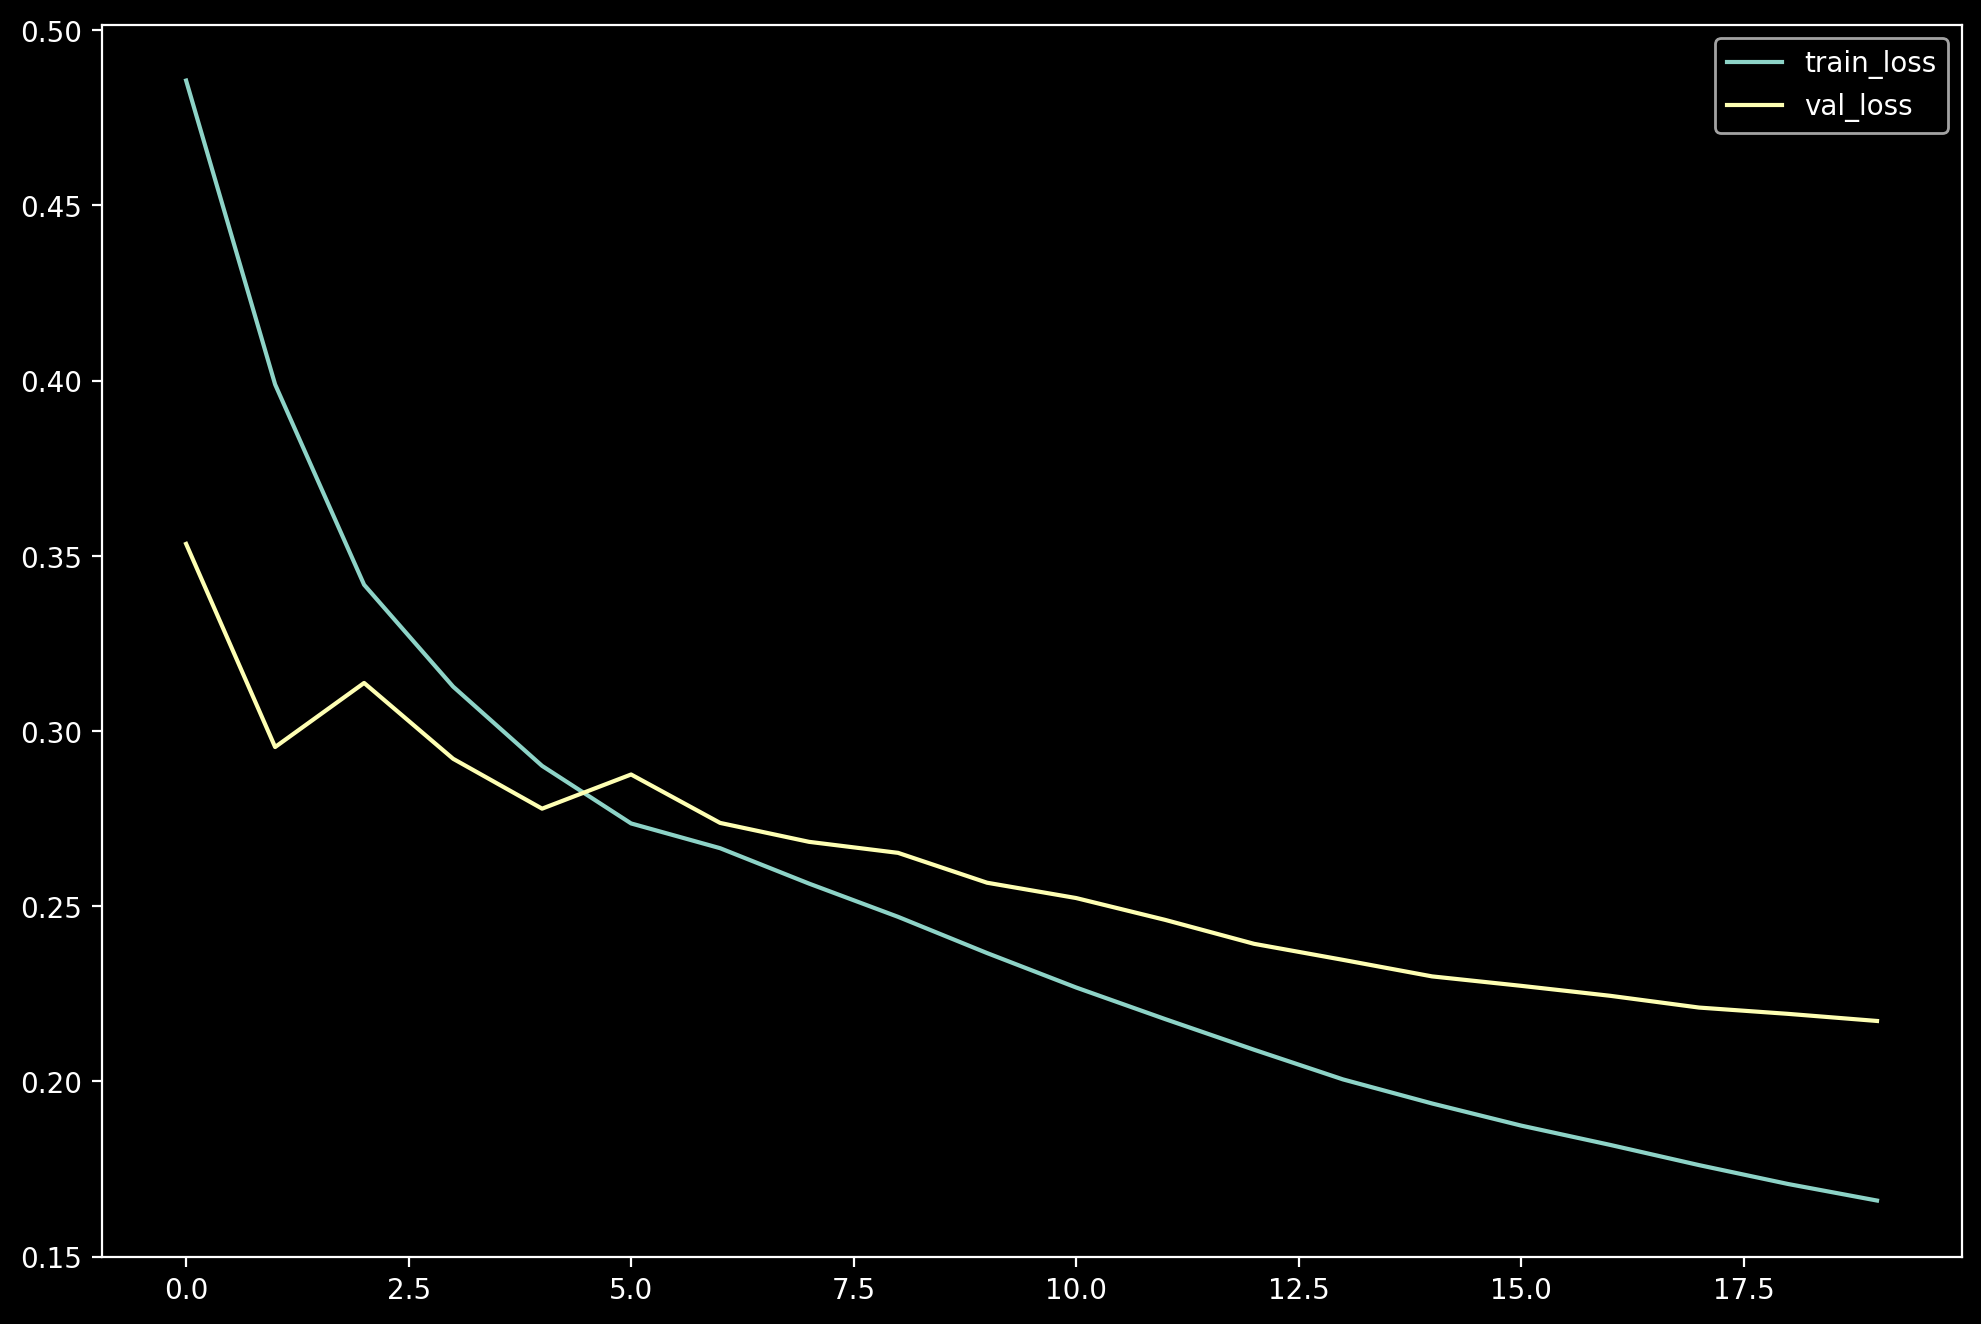

In [99]:
plt.figure(figsize=(12, 8), dpi=200)
plt.plot(range(epochs), train_loss, label='train_loss')
plt.plot(range(epochs), val_loss, label='val_loss')
plt.legend()
plt.show()

## Test

In [31]:
accs = []

for iteration, (X_batch, y_batch) in (pbar := tqdm(enumerate(test_loader),                                                 
                                                  colour='#ff0000', 
                                                  total=len(test_loader))):
    rnn.eval()
    X_batch = X_batch.to(DEVICE)
    y_batch = y_batch.to(DEVICE)
    
    with torch.no_grad():
        out = rnn(X_batch)
        
        acc = accuracy(out, y_batch)
        
    accs.append(acc.detach().cpu().numpy().item())

100%|██████████| 412/412 [00:02<00:00, 205.26it/s]


In [32]:
np.mean(accs)

0.949757274348759